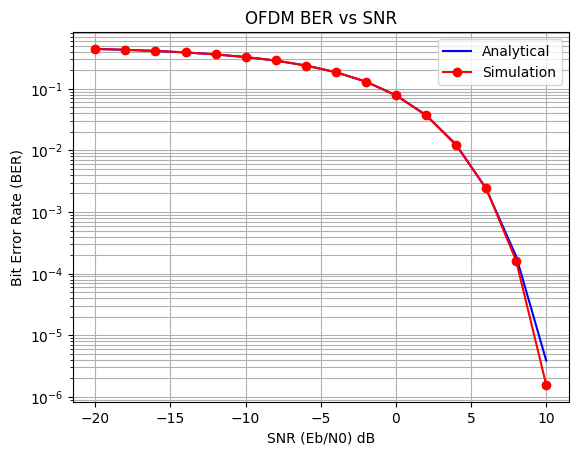

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# Parameters
nFFT = 64  # FFT size
nDSC = 64  # Number of data subcarriers
nBitPerSym = 64  # Bits per OFDM symbol (BPSK: 1 bit per subcarrier)
nSym = 10**4  # Number of OFDM symbols
EbN0dB = np.arange(-20, 11, 2)  # SNR range

theoryBer = (1/2) * erfc(np.sqrt(10**(EbN0dB/10)))
simBer = np.zeros(len(EbN0dB))

for k in range(len(EbN0dB)):
    # Transmitter
    ipBit = np.random.randint(0, 2, nBitPerSym * nSym)
    ipMod = 2 * ipBit - 1  # BPSK modulation: 0 -> -1, 1 -> +1
    ipMod = ipMod.reshape((nSym, nBitPerSym))  # Reshape into symbols
    
    # Assigning modulated symbols to subcarriers
    xF = ipMod
    
    # Taking IFFT, normalize power
    xt = (nFFT / np.sqrt(nDSC)) * np.fft.ifft(np.fft.fftshift(xF, axes=1), axis=1)
    
    # Parallel to serial
    xt = xt.flatten()
    
    # Add AWGN noise
    noise = (1/np.sqrt(2)) * (np.random.randn(len(xt)) + 1j * np.random.randn(len(xt)))
    yt = xt + 10**(-EbN0dB[k]/20) * noise
    
    # Receiver: Serial to parallel
    yt = yt.reshape((nSym, nFFT))
    
    # Convert to frequency domain
    yF = np.fft.fftshift(np.fft.fft(yt, axis=1), axes=1)
    
    # Parallel to serial
    yMod = yF.flatten()
    
    # Hard decision decoding for BPSK demodulation
    ipBitHat = ((np.real(yMod) > 0)).astype(int)
    
    # Count errors
    nErr = np.sum(ipBitHat != ipBit)
    simBer[k] = nErr / (nSym * nBitPerSym)

# Plot BER vs SNR
plt.figure()
plt.semilogy(EbN0dB, theoryBer, 'b-', label='Analytical')
plt.semilogy(EbN0dB, simBer, 'ro-', label='Simulation')
plt.xlabel('SNR (Eb/N0) dB')
plt.ylabel('Bit Error Rate (BER)')
plt.title('OFDM BER vs SNR')
plt.legend()
plt.grid(True, which='both')
plt.show()